In [ ]:
!git clone https://github.com/valleballe/deceptive-ai.git

Cloning into 'deceptive-ai'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 96 (delta 39), reused 63 (delta 20), pack-reused 0
Receiving objects: 100% (96/96), 4.52 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
%cd /content/deceptive-ai/

/content/deceptive-ai


In [ ]:
!pip install stargazer

In [ ]:
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

from scipy.stats import ttest_ind
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math
import seaborn as sns


warnings.filterwarnings('ignore')
%matplotlib inline

# color palette
palette1 = "#007BFF"
palette2 = "#3ABFC2"
palette3 = "#E1C081"
palette4 = "#E17A57"
palette5 = "#D92D3F"

red = 'crimson'
darkred = 'firebrick'
blue = 'lightskyblue'
darkblue = 'steelblue'
lightgrey = 'lightgrey'
darkgrey = 'darkgrey'

# load processed results
df = pd.read_csv("data/results/results_processed.csv")

# creating dummy variables aka binary features
df["trivia"] = (df.stimulation=="trivia").astype(int)
df["true_statement"] = (df.ground_truth==True).astype(int)
df["explanation"] = (df.condition=="flag+explanation").astype(int)
df["text_explanation"] = "No Explanation"
df.loc[df.explanation==1,"text_explanation"] = "GPT Explanation"
df["deceptive_feedback"] = (df.explanation_type=="Deceptive").astype(int)
df["honest_feedback"] = (df.explanation_type=="Honest").astype(int)
df["valid_statement"] = (df.logical_validity=="VALID").astype(int)
df["invalid_statement"] = (df.logical_validity!="VALID").astype(int)


# Delta
df["rating_delta"] = df.second_rating - df.initial_rating
df['z_rating_delta'] = (df.rating_delta - df.rating_delta.mean())/df.rating_delta.std()


# z_scored moderators
#df["z_valid_statement"] = (df.valid_statement - df.valid_statement.mean())/df.valid_statement.std()
#df["z_invalid_statement"] = (df.invalid_statement - df.invalid_statement.mean())/df.invalid_statement.std()
df["z_crt"] = (df.CRT - df.CRT.mean())/df.CRT.std()
df["z_trust"] = (df.trust - df.trust.mean())/df.trust.std()
df["z_knowledge"] = (df.knowledge - df.knowledge.mean())/df.knowledge.std()

# Calculate accuracy
df['initial_rating_accuracy'] = df.apply(lambda x: 1 - abs( x.true_statement - x['initial_rating']/5 ), axis=1)
df['second_rating_accuracy']  = df.apply(lambda x: 1 - abs( x.true_statement - x['second_rating'] /5 ), axis=1)
df['rating_delta_accuracy']  = df.second_rating_accuracy - df.initial_rating_accuracy
df['z_rating_delta_accuracy'] = (df.rating_delta_accuracy - df.rating_delta_accuracy.mean())/df.rating_delta_accuracy.std()

# Interactions
df["deceptive_feedback_x_true_statement"] = df["deceptive_feedback"]*df["true_statement"]
df["deceptive_feedback_x_ts_x_explanation"] = df["deceptive_feedback"]*df["explanation"]*df["true_statement"]
df["deceptive_feedback_x_true_statement_x_explanation"] = df["deceptive_feedback"]*df["explanation"]*df["true_statement"]
df["honest_feedback_x_explanation"] = df["honest_feedback"]*df["explanation"]
df["honest_feedback_x_true_statement"] = df["honest_feedback"]*df["true_statement"]
df["honest_feedback_x_ts_x_explanation"] = df["honest_feedback"]*df["explanation"]*df["true_statement"]
df["explanation_x_true_statement"] = df["explanation"]*df["true_statement"]
df["explanation_x_deceptive_feedback"] = df["deceptive_feedback"]*df["explanation"]

In [ ]:
print([col for col in df.columns])

['PROLIFIC_PID', 'order', 'initial_rating', 'second_rating', 'knowledge', 'page_1_time', 'page_2_time', 'stimulus_ID', 'explanation_type', 'RecordedDate', 'Duration (in seconds)', 'Comments', 'trust', 'NFC', 'CRT', 'condition', 'stimulation', 'ground_truth', 'topic', 'logical_validity', 'trivia', 'true_statement', 'explanation', 'text_explanation', 'deceptive_feedback', 'honest_feedback', 'valid_statement', 'invalid_statement', 'rating_delta', 'z_rating_delta', 'z_crt', 'z_trust', 'z_knowledge', 'initial_rating_accuracy', 'second_rating_accuracy', 'rating_delta_accuracy', 'z_rating_delta_accuracy', 'deceptive_feedback_x_true_statement', 'deceptive_feedback_x_ts_x_explanation', 'deceptive_feedback_x_true_statement_x_explanation', 'honest_feedback_x_explanation', 'honest_feedback_x_true_statement', 'honest_feedback_x_ts_x_explanation', 'explanation_x_true_statement', 'explanation_x_deceptive_feedback']


In [ ]:
df[['explanation_type', 'text_explanation', 'explanation']].head(20)

,explanation_type,text_explanation,explanation
0,Honest,No Explanation,0
1,Honest,No Explanation,0
2,Deceptive,GPT Explanation,1
3,Deceptive,GPT Explanation,1
4,Deceptive,GPT Explanation,1
5,Honest,No Explanation,0
6,Honest,No Explanation,0
7,Honest,GPT Explanation,1
8,Honest,No Explanation,0
9,Deceptive,No Explanation,0


In [ ]:
print(f"Total participants: {df.PROLIFIC_PID.nunique()}")
print(df.groupby("trivia").PROLIFIC_PID.count()/20)
print(df.groupby("true_statement").PROLIFIC_PID.count()/20)
print(df.groupby("explanation").PROLIFIC_PID.count()/20)
print(df['deceptive_feedback'].mean())
print(df['true_statement'].mean())


print(df.groupby(["trivia","explanation"])["PROLIFIC_PID"].nunique()) #"true_statement", "deceptive_feedback"

Total participants: 1199
trivia
0    589.0
1    610.0
Name: PROLIFIC_PID, dtype: float64
true_statement
0    585.25
1    613.75
Name: PROLIFIC_PID, dtype: float64
explanation
0    588.0
1    611.0
Name: PROLIFIC_PID, dtype: float64
0.5037531276063386
0.5118849040867389
trivia  explanation
0       0              289
        1              300
1       0              299
        1              311
Name: PROLIFIC_PID, dtype: int64


# PROOF OF CONCEPT

In [ ]:
#### PROOF OF CONCEPT


x = []

i = df.copy()
i.stimulus_ID = i.stimulus_ID.astype(int)
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
res = sm.OLS(
        i["second_rating"],
        sm.add_constant(i[[
            'true_statement',
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
x.append(res)
res = sm.OLS(
        i["z_rating_delta_accuracy"],
        sm.add_constant(i[[
            'true_statement',
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
x.append(res)

# By stimulus types
for j in [0,1]:
    i = df[(df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating"],
            sm.add_constant(i[[
                'true_statement',
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
    res = sm.OLS(
            i["z_rating_delta_accuracy"],
            sm.add_constant(i[[
                'true_statement',
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],x[4],x[5]])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                          ])

stargazer.custom_columns(['All Items (2nd Rating)','All Items (Delta Acc)','News Headlines (2nd Rating)','News Headlines (Delta Acc)','Trivia Items (2nd Rating)','Trivia Items (Delta Acc)',],
                         [1,1,1,1,
                           1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True',
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values_str = []
for res in x:
    p_value_str = ', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values_str.append(p_value_str)

HTML(stargazer.render_html())

# Prereg

In [ ]:
#### H2: testing whether honest or deceptive explanations increase discernment across conditions


x = []

i = df[df.explanation == 1].copy()
i.stimulus_ID = i.stimulus_ID.astype(int)
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
"""
res = sm.OLS(
        i["second_rating"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            'deceptive_feedback_x_true_statement',
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
x.append(res)
res = sm.OLS(
        i["z_rating_delta_accuracy"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            'deceptive_feedback_x_true_statement',
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
x.append(res)
"""

# By stimulus types
for j in [0,1]:
    i = df[(df.explanation == 1) & (df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'deceptive_feedback_x_true_statement',
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
    """
    res = sm.OLS(
            i["z_rating_delta_accuracy"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'deceptive_feedback_x_true_statement',
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
    """
stargazer = Stargazer([x[0],x[1]#,x[2],x[3],x[4],x[5]
                       ])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'deceptive_feedback',
                            'deceptive_feedback_x_true_statement',
                          ])

stargazer.custom_columns([
                          #'All Items (2nd Rating)','All Items (Delta Acc)',
                          'News Headlines (2nd Rating)', 'Trivia Items (2nd Rating)'],
                         [#1,1,1,1,
                           1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True',
                            'deceptive_feedback':"Deceptive Explanations",
                            'deceptive_feedback_x_true_statement': "Deceptive Explanations * True Statement",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values = []
for res in x:
    p_value_str = ', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values.append(p_value_str)

HTML(stargazer.render_html())

In [ ]:
p_values

['const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, deceptive_feedback_x_true_statement: 0.0000',
 'const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, deceptive_feedback_x_true_statement: 0.0000']

In [ ]:
#### H2: testing whether honest or deceptive explanations increase discernment across conditions


x = []

i = df[df.explanation == 1].copy()
i.stimulus_ID = i.stimulus_ID.astype(int)
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes


# By stimulus types
for j in [0,1]:
    i = df[(df.explanation == 1) & (df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating"],
            sm.add_constant(i[[
                'true_statement',
                'honest_feedback',
                'honest_feedback_x_true_statement',
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
    """
    res = sm.OLS(
            i["z_rating_delta_accuracy"],
            sm.add_constant(i[[
                'true_statement',
                'honest_feedback',
                'honest_feedback_x_true_statement',
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
    """
stargazer = Stargazer([x[0],x[1]#,x[2],x[3],x[4],x[5]
                       ])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'honest_feedback',
                            'honest_feedback_x_true_statement',
                          ])

stargazer.custom_columns([
                          #'All Items (2nd Rating)','All Items (Delta Acc)',
                          'News Headlines (2nd Rating)', 'Trivia Items (2nd Rating)'],
                         [#1,1,1,1,
                           1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True',
                            'honest_feedback':"Honest Explanations",
                            'honest_feedback_x_true_statement': "Honest Explanations * True Statement",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values = []
for res in x:
    p_value_str = ', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values.append(p_value_str)

HTML(stargazer.render_html())

In [ ]:
p_values

['const: 0.0000, true_statement: 0.2309, honest_feedback: 0.0000, honest_feedback_x_true_statement: 0.0000',
 'const: 0.0000, true_statement: 0.0000, honest_feedback: 0.0000, honest_feedback_x_true_statement: 0.0000']

In [ ]:
#### H1: testing whether honest or deceptive explanations increase discernment across conditions ## fully connected model

x = []

i = df.copy()
i.stimulus_ID = i.stimulus_ID.astype(int)
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
res = sm.OLS(
        i["second_rating"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            'explanation',
            "deceptive_feedback_x_true_statement",
            'explanation_x_true_statement',
            'explanation_x_deceptive_feedback',
            "deceptive_feedback_x_ts_x_explanation"
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
res.dvar = "All (2nd Rating)"
x.append(res)
res = sm.OLS(
        i["z_rating_delta"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            'explanation',
            "deceptive_feedback_x_true_statement",
            'explanation_x_true_statement',
            'explanation_x_deceptive_feedback',
            "deceptive_feedback_x_ts_x_explanation"
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
res.dvar = "All (Delta Acc)"
x.append(res)

# By stimulus types
for j in [0,1]:
    i = df[(df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'explanation',
                "deceptive_feedback_x_true_statement",
                'explanation_x_true_statement',
                'explanation_x_deceptive_feedback',
                "deceptive_feedback_x_ts_x_explanation"
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    res.dvar = "Trivia (2nd Rating)" if j == 1 else "News (2nd Rating)"
    x.append(res)
    res = sm.OLS(
            i["z_rating_delta"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'explanation',
                "deceptive_feedback_x_true_statement",
                'explanation_x_true_statement',
                'explanation_x_deceptive_feedback',
                "deceptive_feedback_x_ts_x_explanation"
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    res.dvar = "Trivia (Delta Rating)" if j == 1 else "News (Delta Rating)"
    x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],x[4],x[5]])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'explanation',
                            'deceptive_feedback',
                            'explanation_x_true_statement',
                            "deceptive_feedback_x_true_statement",
                            'explanation_x_deceptive_feedback',
                            "deceptive_feedback_x_ts_x_explanation"
                          ])

stargazer.custom_columns(['All Items (2nd Rating)','All Items (Delta Rating)','News Headlines (2nd Rating)','News Headlines (Delta Rating)','Trivia Items (2nd Rating)','Trivia Items (Delta Rating)',],
                         [1,1,1,1,
                           1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True Statement',
                            'explanation':"LLM Explanation",
                            'deceptive_feedback':'Deceptive Feedback',
                            "deceptive_feedback_x_true_statement": "Deceptive Feedback * True Statement",
                            'explanation_x_true_statement': "LLM Explanation * True Statement",
                            'explanation_x_deceptive_feedback': "Deceptive Feedback * LLM Explanation",
                            "deceptive_feedback_x_ts_x_explanation": "Deceptive Feedback * LLM Explanation * True Statement"
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values_str = []
for res in x:
    p_value_str = res.dvar+': '+', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values_str.append(p_value_str)

HTML(stargazer.render_html())
#latex_table = stargazer.render_latex()
#print(latex_table)

In [ ]:
for p in p_values_str:
  print(p)

All (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.3869, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.0177, explanation_x_deceptive_feedback: 0.1893, deceptive_feedback_x_ts_x_explanation: 0.0013
All (Delta Acc): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.6596, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.1359, explanation_x_deceptive_feedback: 0.4860, deceptive_feedback_x_ts_x_explanation: 0.0015
News (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.2107, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.0085, explanation_x_deceptive_feedback: 0.0081, deceptive_feedback_x_ts_x_explanation: 0.0001
News (Delta Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.3119, deceptive_feedback_x_true_statement: 0.0000, explanation_x_t

In [ ]:
#### H1: testing whether honest or deceptive explanations increase discernment across conditions ## fully connected model

x = []

# By stimulus types
for j in [0,1]:
    i = df[(df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'explanation',
                "deceptive_feedback_x_true_statement",
                'explanation_x_true_statement',
                'explanation_x_deceptive_feedback',
                "deceptive_feedback_x_ts_x_explanation"
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    res.dvar = "Trivia" if j == 1 else "News"
    x.append(res)
stargazer = Stargazer([x[0],x[1]])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'explanation',
                            'deceptive_feedback',
                            'explanation_x_true_statement',
                            "deceptive_feedback_x_true_statement",
                            'explanation_x_deceptive_feedback',
                            "deceptive_feedback_x_ts_x_explanation"
                          ])

stargazer.custom_columns(['News Headlines','Trivia Items',],
                         [1,1,
                          #1,1,
                          #1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True Statement',
                            'explanation':"LLM Explanation",
                            'deceptive_feedback':'Deceptive Feedback',
                            "deceptive_feedback_x_true_statement": "Deceptive Feedback * True Statement",
                            'explanation_x_true_statement': "LLM Explanation * True Statement",
                            'explanation_x_deceptive_feedback': "Deceptive Feedback * LLM Explanation",
                            "deceptive_feedback_x_ts_x_explanation": "Deceptive Feedback * LLM Explanation * True Statement"
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values = []
for res in x:
    p_value_str = ', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values.append(p_value_str)

HTML(stargazer.render_html())
#latex_table = stargazer.render_latex()
#print(latex_table)

In [ ]:
p_values

['const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.2107, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.0085, explanation_x_deceptive_feedback: 0.0081, deceptive_feedback_x_ts_x_explanation: 0.0001',
 'const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.7277, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.3146, explanation_x_deceptive_feedback: 0.9373, deceptive_feedback_x_ts_x_explanation: 0.1905']

In [ ]:
#### testing whether honest or deceptive explanations increase discernment


x = []

# regardless of stimulus type
i = df.copy()
i.stimulus_ID = i.stimulus_ID.astype(int)
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
res = sm.OLS(
        i["second_rating"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            "deceptive_feedback_x_true_statement",
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
x.append(res)
res = sm.OLS(
        i["z_rating_delta"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            "deceptive_feedback_x_true_statement",
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
x.append(res)




# by stimulus type
for j in [0,1]:
    i = df[(df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                "deceptive_feedback_x_true_statement",
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
    res = sm.OLS(
            i["z_rating_delta"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                "deceptive_feedback_x_true_statement",
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                        x[4],x[5]
                      ])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'deceptive_feedback',
                            "deceptive_feedback_x_true_statement",
                          ])

stargazer.custom_columns(['All Items (2nd Rating)', 'All Items (Delta Acc)', 'News Headlines (2nd Rating)','News Headlines (Delta Acc)','Trivia Items (2nd Rating)','Trivia Items (Delta Acc)',],
                         [1,1,1,1,
                           1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True',
                            'deceptive_feedback':'Deceptive Feedback',
                            "deceptive_feedback_x_true_statement": "Deceptive Feedback * True Statement",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values_str = []
for res in x:
    p_value_str = ', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values_str.append(p_value_str)

HTML(stargazer.render_html())

#latex_table = stargazer.render_latex()
#print(latex_table)

# Accuracy

In [ ]:
## accuracy version of fully interacted model


x = []

i = df.copy()
i.stimulus_ID = i.stimulus_ID.astype(int)
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
res = sm.OLS(
        i["second_rating_accuracy"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            'explanation',
            "deceptive_feedback_x_true_statement",
            'explanation_x_true_statement',
            'explanation_x_deceptive_feedback',
            "deceptive_feedback_x_ts_x_explanation"
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
res.dvar = "All (2nd Rating Accuracy)"
x.append(res)
res = sm.OLS(
        i["z_rating_delta_accuracy"],
        sm.add_constant(i[[
            'true_statement',
            'deceptive_feedback',
            'explanation',
            "deceptive_feedback_x_true_statement",
            'explanation_x_true_statement',
            'explanation_x_deceptive_feedback',
            "deceptive_feedback_x_ts_x_explanation"
        ]]),
        M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
res.summary()
res.dvar = "All (Delta Rating Accuracy)"
x.append(res)

# By stimulus types
for j in [0,1]:
    i = df[(df.trivia==j)]
    i.stimulus_ID = i.stimulus_ID.astype(int)
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["second_rating_accuracy"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'explanation',
                "deceptive_feedback_x_true_statement",
                'explanation_x_true_statement',
                'explanation_x_deceptive_feedback',
                "deceptive_feedback_x_ts_x_explanation"
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    res.dvar = "Trivia (2nd Rating Accuracy)" if j == 1 else "News (2nd Rating Accuracy)"
    x.append(res)
    res = sm.OLS(
            i["z_rating_delta_accuracy"],
            sm.add_constant(i[[
                'true_statement',
                'deceptive_feedback',
                'explanation',
                "deceptive_feedback_x_true_statement",
                'explanation_x_true_statement',
                'explanation_x_deceptive_feedback',
                "deceptive_feedback_x_ts_x_explanation"
            ]]),
            M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
    res.summary()
    res.dvar = "Trivia (Delta Rating Accuracy)" if j == 1 else "News (Delta Rating Accuracy)"
    x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],x[4],x[5]])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'explanation',
                            'deceptive_feedback',
                            'explanation_x_true_statement',
                            "deceptive_feedback_x_true_statement",
                            'explanation_x_deceptive_feedback',
                            "deceptive_feedback_x_ts_x_explanation"
                          ])

stargazer.custom_columns(['All Items (2nd Rating Acc)','All Items (Delta Rating Acc)','News Headlines (2nd Rating Acc)','News Headlines (Delta Rating Acc)','Trivia Items (2nd Rating Acc)','Trivia Items (Delta Rating Acc)',],
                         [1,1,1,1,
                           1,1
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement':'True Statement',
                            'explanation':"LLM Explanation",
                            'deceptive_feedback':'Deceptive Feedback',
                            "deceptive_feedback_x_true_statement": "Deceptive Feedback * True Statement",
                            'explanation_x_true_statement': "LLM Explanation * True Statement",
                            'explanation_x_deceptive_feedback': "Deceptive Feedback * LLM Explanation",
                            "deceptive_feedback_x_ts_x_explanation": "Deceptive Feedback * LLM Explanation * True Statement"
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values_str = []
for res in x:
    p_value_str = res.dvar+': '+', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values_str.append(p_value_str)

HTML(stargazer.render_html())

In [ ]:
for p in p_values_str:
  print(p)

All (2nd Rating Accuracy): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.3869, deceptive_feedback_x_true_statement: 0.0468, explanation_x_true_statement: 0.1511, explanation_x_deceptive_feedback: 0.1893, deceptive_feedback_x_ts_x_explanation: 0.0484
All (Delta Rating Accuracy): const: 0.0000, true_statement: 0.8617, deceptive_feedback: 0.0000, explanation: 0.6596, deceptive_feedback_x_true_statement: 0.1207, explanation_x_true_statement: 0.0105, explanation_x_deceptive_feedback: 0.4860, deceptive_feedback_x_ts_x_explanation: 0.0006
News (2nd Rating Accuracy): const: 0.0000, true_statement: 0.0294, deceptive_feedback: 0.0000, explanation: 0.2107, deceptive_feedback_x_true_statement: 0.0011, explanation_x_true_statement: 0.2200, explanation_x_deceptive_feedback: 0.0081, deceptive_feedback_x_ts_x_explanation: 0.4730
News (Delta Rating Accuracy): const: 0.0000, true_statement: 0.0062, deceptive_feedback: 0.0000, explanation: 0.3119, deceptive_feedback_x_

# Discernment

In [ ]:
# Discernment
df_discernment = df.groupby(['PROLIFIC_PID', 'true_statement', 'explanation', 'deceptive_feedback', 'trivia'])['second_rating'].mean().reset_index() \
    .pivot_table(index=['PROLIFIC_PID', 'explanation', 'deceptive_feedback', 'trivia'], columns='true_statement', values='second_rating').reset_index() \
    .assign(discernment=lambda x: x[1].astype(float) - x[0].astype(float))[['PROLIFIC_PID', 'explanation', 'deceptive_feedback', 'trivia', 'discernment']] \
    .rename_axis(None, axis=1)

# Add moderators
'z_valid_statement', 'z_crt', 'z_trust', 'z_knowledge'
# Merge the two dataframes on "PROLIFIC_PID" column
df_discernment = df_discernment.merge(df[['PROLIFIC_PID', 'z_valid_statement', 'z_crt', 'z_trust', 'z_knowledge']], on='PROLIFIC_PID', how='left')

# Discernment Interactions
df_discernment["explanation_x_deceptive_feedback"] = df_discernment["deceptive_feedback"]*df_discernment["explanation"]
df_discernment["explanation_x_z_valid_statement"] = df_discernment["z_valid_statement"]*df_discernment["explanation"]
df_discernment["deceptive_feedback_x_z_valid_statement"] = df_discernment["z_valid_statement"]*df_discernment["deceptive_feedback"]

# some only had true or false statements
print(df_discernment.isna().sum())

# remove those participants
df_discernment = df_discernment.dropna(subset=['discernment'])
print('\n---After dropping NaN participants---')
print(df_discernment.isna().sum())

PROLIFIC_PID                                0
explanation                                 0
deceptive_feedback                          0
trivia                                      0
discernment                               140
z_valid_statement                           0
z_crt                                       0
z_trust                                     0
z_knowledge                                 0
explanation_x_deceptive_feedback            0
explanation_x_z_valid_statement             0
deceptive_feedback_x_z_valid_statement      0
dtype: int64

---After dropping NaN participants---
PROLIFIC_PID                              0
explanation                               0
deceptive_feedback                        0
trivia                                    0
discernment                               0
z_valid_statement                         0
z_crt                                     0
z_trust                                   0
z_knowledge                               0


In [ ]:
## accuracy version of fully interacted model


x = []

i = df_discernment.copy()
i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
res = sm.OLS(
        i["discernment"],
        sm.add_constant(i[[
            'deceptive_feedback',
            'explanation',
            'explanation_x_deceptive_feedback',
        ]]),
        M=sm.robust.norms.HuberT()).fit()
res.summary()
res.dvar = "All (Discernment)"
x.append(res)

# By stimulus types
for j in [0,1]:
    i = df_discernment[(df_discernment.trivia==j)]
    i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
    i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
    res = sm.OLS(
            i["discernment"],
            sm.add_constant(i[[
                'deceptive_feedback',
                'explanation',
                'explanation_x_deceptive_feedback',
            ]]),
            M=sm.robust.norms.HuberT()).fit()
    res.summary()
    res.dvar = "Trivia (Discernment)" if j == 1 else "News (Discernment)"
    x.append(res)
stargazer = Stargazer([x[0],x[1],x[2]])
stargazer.covariate_order([
                            'const',
                            'explanation',
                            'deceptive_feedback',
                            'explanation_x_deceptive_feedback',
                          ])

stargazer.custom_columns(['All Items (Discernment)', 'News Headlines (Discernment)', 'Trivia Items (Discernment)'],
                         [1,1,1,
                         ])

stargazer.rename_covariates({
                            'const':'Constant',
                            'explanation':"LLM Explanation",
                            'deceptive_feedback':'Deceptive Feedback',
                            'explanation_x_deceptive_feedback': "Deceptive Feedback * LLM Explanation",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)

p_values_str = []
for res in x:
    p_value_str = res.dvar+': '+', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
    p_values_str.append(p_value_str)

HTML(stargazer.render_html())

In [ ]:
p_values_str

['All (Discernment): const: 0.0000, deceptive_feedback: 0.0000, explanation: 0.0266, explanation_x_deceptive_feedback: 0.0000',
 'News (Discernment): const: 0.0000, deceptive_feedback: 0.0000, explanation: 0.0401, explanation_x_deceptive_feedback: 0.0000',
 'Trivia (Discernment): const: 0.0000, deceptive_feedback: 0.0000, explanation: 0.1984, explanation_x_deceptive_feedback: 0.0501']

# Moderators

 In particular, we will re-run the main analysis model restricting to the flag + explanation condition, with the addition of the z-scored moderator and all interactions (so no flag condition dummy). We will examine the 3-way interaction between veracity, explanation veracity, explanation type and the moderator.

In [ ]:
import itertools
from functools import reduce
import operator
import tqdm.notebook as tqdm
import numpy as np
from itertools import product



moderator_vars =    [
                    'valid_statement',
                    'invalid_statement',
                    'z_crt',
                    'z_trust',
                    'z_knowledge'
                    ]


independent_vars = ['true_statement',
                    'deceptive_feedback',
                    'explanation',
                    "deceptive_feedback_x_true_statement",
                    'explanation_x_true_statement',
                    'explanation_x_deceptive_feedback',
                    "deceptive_feedback_x_true_statement_x_explanation"
                    ]

# Create dataframe
all_vars = np.append(independent_vars, moderator_vars)
#df_moderators = df[df.explanation==1].copy()
df_moderators = df.copy()
df_moderators = df_moderators[np.append(['PROLIFIC_PID', 'stimulus_ID', 'initial_rating','second_rating', 'second_rating_accuracy', 'trivia'], all_vars)].copy()

combinations = sorted(set('_x_'.join(sorted(pair)) for pair in product(moderator_vars, independent_vars)))

# Multiplying columns based on the combinations
for combination in combinations:
    combination_split = combination.split('_x_')
    df_moderators[combination] = reduce(operator.mul, [df_moderators[col] for col in combination_split])

combinations = np.append(all_vars, combinations)
#print(combinations)

**Personal Factors for Second Rating x Knowledge**

second_rating = b0 + b1*deceptive_feedback + b2*explanation + b3*true_statement + b4* z_knowledge + b5*deceptive_feedback*true_statement + b6*explanation*true_statement* + b7*deceptive_feedback*true_statement* + b8*explanation*true_statement* z_knowledge

In [ ]:
def OLS_w_moderators(df_, dvar, moderator, moderator_name):
  x = []

  i = df_.copy()
  i.stimulus_ID = i.stimulus_ID.astype(int)
  i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
  i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
  res = sm.OLS(
          i[dvar],
          sm.add_constant(i[[
              'true_statement',
              'deceptive_feedback',
              'explanation',
              moderator,
              "deceptive_feedback_x_true_statement",
              'explanation_x_true_statement',
              'explanation_x_deceptive_feedback',
              'true_statement_x_'+moderator,
              'explanation_x_'+moderator,
              'deceptive_feedback_x_'+moderator,
              'explanation_x_true_statement_x_'+moderator,
              'explanation_x_deceptive_feedback_x_'+moderator,
              'deceptive_feedback_x_true_statement_x_'+moderator,
              'deceptive_feedback_x_true_statement_x_explanation_x_'+moderator
          ]]),
          M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
  res.summary()
  res.dvar = f"All ({dvar})"
  x.append(res)

  # By stimulus types
  for j in [0,1]:
      i = df_moderators[(df_moderators.trivia==j)]
      i.stimulus_ID = i.stimulus_ID.astype(int)
      i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
      i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
      res = sm.OLS(
              i[dvar],
              sm.add_constant(i[[
                  'true_statement',
                  'deceptive_feedback',
                  'explanation',
                  moderator,
                  "deceptive_feedback_x_true_statement",
                  'explanation_x_true_statement',
                  'explanation_x_deceptive_feedback',
                  'deceptive_feedback_x_true_statement_x_explanation',
                  'true_statement_x_'+moderator,
                  'explanation_x_'+moderator,
                  'deceptive_feedback_x_'+moderator,
                  'explanation_x_true_statement_x_'+moderator,
                  'explanation_x_deceptive_feedback_x_'+moderator,
                  'deceptive_feedback_x_true_statement_x_'+moderator,
                  'deceptive_feedback_x_true_statement_x_explanation_x_'+moderator
              ]]),
              M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
      res.summary()
      res.dvar = "Trivia (2nd Rating)" if j == 1 else "News (2nd Rating)"
      x.append(res)

  stargazer = Stargazer([x[0],x[1],x[2]])

  stargazer.covariate_order([
                              'const',
                              'true_statement',
                              'deceptive_feedback',
                              'explanation',
                              moderator,
                              "deceptive_feedback_x_true_statement",
                              'explanation_x_true_statement',
                              'explanation_x_deceptive_feedback',
                              'deceptive_feedback_x_true_statement_x_explanation',
                              'true_statement_x_'+moderator,
                              'explanation_x_'+moderator,
                              'deceptive_feedback_x_'+moderator,
                              'explanation_x_true_statement_x_'+moderator,
                              'explanation_x_deceptive_feedback_x_'+moderator,
                              'deceptive_feedback_x_true_statement_x_'+moderator,
                              'deceptive_feedback_x_true_statement_x_explanation_x_'+moderator
                            ])

  stargazer.rename_covariates({
                              'const':'Constant',
                              'true_statement':'True Statement',
                              'explanation':"LLM Explanation",
                              moderator:moderator_name,
                              'deceptive_feedback':'Deceptive Feedback',
                              "deceptive_feedback_x_true_statement": "Deceptive Feedback * True Statement",
                              'explanation_x_true_statement': "LLM Explanation * True Statement",
                              'explanation_x_deceptive_feedback': "Deceptive Feedback * LLM Explanation",
                              "deceptive_feedback_x_ts_x_explanation": "Deceptive Feedback * LLM Explanation * True Statement",
                              'deceptive_feedback_x_true_statement_x_explanation': f"True Statement * LLM Explanation * Deceptive Feedback",
                              f'true_statement_x_{moderator}': f"True Statement * {moderator_name}",
                              f'explanation_x_{moderator}': f"LLM Explanation * {moderator_name}",
                              f'deceptive_feedback_x_{moderator}': f"Deceptive Feedback * {moderator_name}",
                              f'explanation_x_true_statement_x_{moderator}': f"True Statement * LLM Explanation * {moderator_name}",
                              f'explanation_x_deceptive_feedback_x_{moderator}': f"LLM Explanation * Deceptive Feedback * {moderator_name}",
                               'deceptive_feedback_x_true_statement_x_'+moderator : f"True Statement * Deceptive Feedback * {moderator_name}",
                              f'deceptive_feedback_x_true_statement_x_explanation_x_{moderator}': f"True Statement * LLM Explanation * Deceptive Feedback * {moderator_name}",
                              })

  stargazer.custom_columns([f'All Items ({dvar})', f'News Headlines ({dvar})',f'Trivia Items ({dvar})'],
                          [1,1,1,
                          ])

  stargazer.significant_digits(2)
  stargazer.show_degrees_of_freedom(False)
  stargazer.significance_levels([0.05, 0.01, 0.001])
  stargazer.show_model_numbers(True)

  p_values_str = []
  for res in x:
      p_value_str = res.dvar+': '+', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
      p_values_str.append(p_value_str)

  return stargazer, p_values_str


stargazer, pvalues = OLS_w_moderators(df_moderators, "initial_rating", 'z_knowledge', 'Prior Knowledge')
HTML(stargazer.render_html())

#latex_table = stargazer.render_latex()
#print(latex_table)

In [ ]:
pvalues

['All (initial_rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.4502, explanation: 0.2839, z_knowledge: 0.0000, deceptive_feedback_x_true_statement: 0.5920, explanation_x_true_statement: 0.3912, explanation_x_deceptive_feedback: 0.2315, true_statement_x_z_knowledge: 0.0000, explanation_x_z_knowledge: 0.4124, deceptive_feedback_x_z_knowledge: 0.0000, explanation_x_true_statement_x_z_knowledge: 0.1900, explanation_x_deceptive_feedback_x_z_knowledge: 0.3315, deceptive_feedback_x_true_statement_x_z_knowledge: 0.0000, deceptive_feedback_x_true_statement_x_explanation_x_z_knowledge: 0.0771',
 'News (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.1443, explanation: 0.4077, z_knowledge: 0.0008, deceptive_feedback_x_true_statement: 0.0304, explanation_x_true_statement: 0.6457, explanation_x_deceptive_feedback: 0.9419, deceptive_feedback_x_true_statement_x_explanation: 0.9836, true_statement_x_z_knowledge: 0.0000, explanation_x_z_knowledge: 0.0372,

**Personal Factors for Second Rating * Trust**

In [ ]:
stargazer, pvalues = OLS_w_moderators(df_moderators, "second_rating", 'z_trust', 'Trust')
HTML(stargazer.render_html())

#latex_table = stargazer.render_latex()
#print(latex_table)

In [ ]:
pvalues

['All (second_rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.1016, z_trust: 0.2955, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.1782, explanation_x_deceptive_feedback: 0.0812, true_statement_x_z_trust: 0.0002, explanation_x_z_trust: 0.8114, deceptive_feedback_x_z_trust: 0.0000, explanation_x_true_statement_x_z_trust: 0.7946, explanation_x_deceptive_feedback_x_z_trust: 0.3765, deceptive_feedback_x_true_statement_x_z_trust: 0.0000, deceptive_feedback_x_true_statement_x_explanation_x_z_trust: 0.8363',
 'News (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.0412, z_trust: 0.1548, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.0996, explanation_x_deceptive_feedback: 0.1323, true_statement_x_z_trust: 0.0034, explanation_x_z_trust: 0.3864, deceptive_feedback_x_z_trust: 0.0000, explanation_x_true_statement_x_z_trust: 0.8905, explanation_x_dec

**Critical Reflection Score**

In [ ]:
stargazer, pvalues = OLS_w_moderators(df_moderators, "second_rating", 'z_crt', 'CRT')
HTML(stargazer.render_html())

#latex_table = stargazer.render_latex()
#print(latex_table)

In [ ]:
pvalues

['All (second_rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.0476, z_crt: 0.0273, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.1197, explanation_x_deceptive_feedback: 0.0724, true_statement_x_z_crt: 0.2192, explanation_x_z_crt: 0.3322, deceptive_feedback_x_z_crt: 0.8898, explanation_x_true_statement_x_z_crt: 0.3921, explanation_x_deceptive_feedback_x_z_crt: 0.8335, deceptive_feedback_x_true_statement_x_z_crt: 0.9777, deceptive_feedback_x_true_statement_x_explanation_x_z_crt: 0.8662',
 'News (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, explanation: 0.0123, z_crt: 0.0494, deceptive_feedback_x_true_statement: 0.0000, explanation_x_true_statement: 0.0224, explanation_x_deceptive_feedback: 0.1685, true_statement_x_z_crt: 0.7687, explanation_x_z_crt: 0.5576, deceptive_feedback_x_z_crt: 0.1979, explanation_x_true_statement_x_z_crt: 0.1190, explanation_x_deceptive_feedback_x_z_crt: 0

**Logical Validity**

In [ ]:
def OLS_w_moderators_validity(df_, dvar, moderator, moderator_name):
  x = []

  # By stimulus types
  for j in [0,1]:
      i = df_moderators[(df_moderators.trivia==j)]
      i.stimulus_ID = i.stimulus_ID.astype(int)
      i.PROLIFIC_PID = pd.Categorical(i.PROLIFIC_PID)
      i['PROLIFIC_PID2'] = i.PROLIFIC_PID.cat.codes
      res = sm.OLS(
              i[dvar],
              sm.add_constant(i[[
                  'true_statement',
                  'deceptive_feedback',
                  moderator,
                  "deceptive_feedback_x_true_statement",
                  'true_statement_x_'+moderator,
                  'deceptive_feedback_x_'+moderator,
                  'deceptive_feedback_x_true_statement_x_'+moderator
              ]]),
              M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': np.array(i[['PROLIFIC_PID2',"stimulus_ID"]])})
      res.summary()
      res.dvar = "Trivia (2nd Rating)" if j == 1 else "News (2nd Rating)"
      x.append(res)

  stargazer = Stargazer([x[0],x[1]])

  stargazer.covariate_order([
                              'const',
                              'true_statement',
                              'deceptive_feedback',
                              moderator,
                              "deceptive_feedback_x_true_statement",
                              'true_statement_x_'+moderator,
                              'deceptive_feedback_x_'+moderator,
                             'deceptive_feedback_x_true_statement_x_'+moderator
                            ])

  stargazer.rename_covariates({
                              'const':'Constant',
                              'true_statement':'True Statement',
                              moderator:moderator_name,
                              'deceptive_feedback':'Deceptive Feedback',
                              "deceptive_feedback_x_true_statement": "Deceptive Feedback * True Statement",
                              f'true_statement_x_{moderator}': f"True Statement * {moderator_name}",
                              f'deceptive_feedback_x_{moderator}': f"Deceptive Feedback * {moderator_name}",
                               'deceptive_feedback_x_true_statement_x_'+moderator : f"True Statement * Deceptive Feedback * {moderator_name}",
                              })

  stargazer.custom_columns([f'News Headlines ({dvar})',f'Trivia Items ({dvar})'],
                          [1,
                           #1,
                           1,
                          ])

  stargazer.significant_digits(2)
  stargazer.show_degrees_of_freedom(False)
  stargazer.significance_levels([0.05, 0.01, 0.001])
  stargazer.show_model_numbers(True)

  p_values_str = []
  for res in x:
      p_value_str = res.dvar+': '+', '.join([f"{var}: {p:.4f}" for var, p in zip(res.params.index, res.pvalues)])
      p_values_str.append(p_value_str)

  return stargazer, p_values_str

In [ ]:
df_explantions_only = df_moderators[df_moderators.explanation==1]

stargazer, pvalues = OLS_w_moderators_validity(df_explantions_only, "second_rating", 'z_valid_statement', 'Logical Validity')
HTML(stargazer.render_html())
#latex_table = stargazer.render_latex()
#print(latex_table)

In [ ]:
pvalues

['News (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, z_valid_statement: 0.1843, deceptive_feedback_x_true_statement: 0.0000, true_statement_x_z_valid_statement: 0.4202, deceptive_feedback_x_z_valid_statement: 0.0152, deceptive_feedback_x_true_statement_x_z_valid_statement: 0.1308',
 'Trivia (2nd Rating): const: 0.0000, true_statement: 0.0000, deceptive_feedback: 0.0000, z_valid_statement: 0.5595, deceptive_feedback_x_true_statement: 0.0000, true_statement_x_z_valid_statement: 0.9536, deceptive_feedback_x_z_valid_statement: 0.4974, deceptive_feedback_x_true_statement_x_z_valid_statement: 0.5613']

In [ ]:
df_explantions_only = df_moderators[df_moderators.explanation==1]

stargazer, pvalues = OLS_w_moderators_validity(df_explantions_only, "second_rating", 'z_invalid_statement', 'Logically Invalid')
HTML(stargazer.render_html())
#latex_table = stargazer.render_latex()
#print(latex_table)

# Plotting

In [ ]:
#@markdown Run simple anovas on the graph - Install libraries

!pip install 'pingouin==0.5.2'
!pip install 'scikit-posthocs == 0.7.0'
!pip install 'statannotations == 0.4.4'

from IPython.display import clear_output
clear_output()

import itertools
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prerun_stats (sample_keys, group_label, data, y, stats_viz=False):

  ## Stats
  import scipy.stats as stats
  from pingouin import welch_anova, pairwise_gameshowell, pairwise_tukey
  from statistics import stdev
  import numpy as np

  MIN_SAMPLE_SIZE = 25
  TOLERANCE = 0.15

  sample_data = [data.copy().apply(lambda z: z[y] if z[group_label] == key else None, axis=1).dropna() for key in sample_keys]
  #sample_data = [data[data[group_label]==key][y] for key in sample_keys]


  sample_data_w_keys = pd.concat([pd.DataFrame({y:data.values, group_label:sample_keys[i]}) for i, data in enumerate(sample_data.copy())], axis=0, ignore_index=True)

  if stats_viz is True:
    print(f"Running stats between the samples: {sample_keys}")

  # Means for each sample group
  means_table = data[group_label].value_counts()

  # Check if *all* data points for each sample group are over 25
  sample_sizes_sufficient = all([sample > MIN_SAMPLE_SIZE for sample in means_table])

  # Check if means are equal within the TOLERANCE for each sample group
  sample_sizes_equal = all([abs(sample1 - sample2) < np.mean(means_table) * TOLERANCE for sample1, sample2 in itertools.combinations(means_table, 2)])

  # Dunn Test
  dunn = sp.posthoc_dunn(sample_data, p_adjust='bonferroni')
  replacer = {i+1:key for i, key in enumerate(sample_keys)}
  dunn.rename(columns = replacer, index=replacer, inplace=True)

  # Compile all stats into list
  statz = {'sample_sizes_sufficient': sample_sizes_sufficient,
          'sample_sizes_equal':      sample_sizes_equal,
          'shapiro':                 stats.shapiro(data[y]),
          'levene':                  stats.levene(*sample_data),
          'f_oneway':                stats.f_oneway(*sample_data),
          'kruskal':                 stats.kruskal(*sample_data),
          'welch_anova':             welch_anova(dv=y, between=group_label, data=sample_data_w_keys),
          'gameshowell':             pairwise_gameshowell(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'tukey':                   pairwise_tukey(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'dunn':                    dunn,
          'mean_std':                {key:{'mean' : np.mean(population), \
                                           'std' : stats.tstd(population)} for key, population in zip(sample_keys, sample_data)},
  }

  return statz



def stats_tree(sample_keys, sample_sizes_sufficient, sample_sizes_equal, shapiro, levene, f_oneway, kruskal, welch_anova, gameshowell, tukey, dunn, mean_std=None, stats_viz=False):

  import itertools

  ALPHA = 0.05
  indent = '   '


  if sample_sizes_sufficient or shapiro.pvalue > ALPHA:
    if stats_viz is True:
      print("> Sample size sufficient" if sample_sizes_sufficient else f">Sample size insufficient but *normality is met*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if sample_sizes_equal or levene.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes equal" if sample_sizes_equal else f"{indent*1}>Sample sizes not equal but *homogeneity is met*: s_levene={levene.statistic}, p_levene={levene.pvalue}")

      if f_oneway.pvalue < ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA (f_oneway) *significant*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}")
          print(f"\n> Thus running Tukey Test:")
          print(tukey)
          print(f"mean_std: {mean_std}")

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()

        return pairs, p_values

      elif f_oneway.pvalue > ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}" if stats_viz is True else "")
          print(f"mean_std: {mean_std}" )

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()

        return pairs, p_values

    elif not sample_sizes_equal or levene.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes are unequal and homogeneity *NOT MET*: w_levene={levene.statistic}, p_levene={levene.pvalue}")

      if welch_anova['p-unc'][0] < ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *SIGNIFICANT*: welch=\n{welch_anova}")#{welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"\n>Thus running Games-Howell test:")
          print(gameshowell)
          print(f"mean_std: {mean_std}")

        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

      elif welch_anova['p-unc'][0] > ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *NOT SIGNIFICANT*: welch=\n{welch_anova}")#F_welch={welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"mean_std: {mean_std}")

        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

  elif not sample_sizes_sufficient or shapiro.pvalue < ALPHA:
    if stats_viz is True:
      print(f"{indent*1}> Both minimum sample size and normality were *NOT MET*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if kruskal.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n Kruskal Wallis *SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"{indent*2}> Running DUNN test:")
        print(dunn)
        print(f"mean_std: {mean_std}")

      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values

    elif kruskal.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n{indent*3}>Kruskal Wallis *NOT SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"mean_std: {mean_std}")

      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values


def plot_stats(pairs, p_values, y, x, title, hue=None, figsize=None, ylim=None, plot_params=None, **kwgs):

  from statannotations.Annotator import Annotator

  if figsize is None:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

  else:
    fig, ax = plt.subplots(figsize=figsize)

  plt.tight_layout()
  sns.barplot(ax=ax,
              alpha=.99,
              errcolor="black",
              errwidth=2,
              capsize=.05,
              **plot_params)

  annot = Annotator(ax, pairs, **plot_params)
  annot.configure(text_format="star", loc="inside")
  annot.set_pvalues_and_annotate(p_values)

  # styling
  #ax.text(x=0.5, y=-0.3, s=lbl, fontsize=10, ha='center', va='bottom', transform=ax.transAxes)

  if title is None:
    ax.set_title(f"{y} for {x}")
  else:
    ax.set_title(title)

  if ylim is not None:
    ax.set_ylim(ylim)

  ax.legend(loc='lower left')
  ax.set_xlabel("")
  #plt.legend(loc='upper left')

  fig.savefig("f1_acc_{}.png".format(title),dpi=600, bbox_inches="tight")

  plt.show()


def stats(data, y, x, hue=None, graph_viz=True, title=None, stats_viz=False, ylim=None, figsize=None, plot_params=None, **kwgs):

  target_data = [data] # The data to be used for statistical analysis
  target_label = x # The column name with the groups to be compared between
  within_sample = [None] # The value of a column for hue groups to be compared within

  if hue is not None:

    within_sample = data[x].unique()
    target_data = [data[data[x]==group] for group in within_sample]
    target_label = hue

  pairs = []
  p_values = []

  for i, data in enumerate(target_data):

    if stats_viz is True:
      print(f"----\nWithin the '{within_sample[i]}' group of '{x}':\n----" if len(within_sample) > 1 else "----")

    sample_keys = [key for key in data[target_label].unique()]
    stat_results = prerun_stats (sample_keys, target_label, data, y, stats_viz=stats_viz)
    pair, p_value = stats_tree(sample_keys, **stat_results, stats_viz=stats_viz)

    for pair_item, p_value_item in zip(pair, p_value):
      if hue is not None:
        pair_item = [pair_w_sample_label for pair_w_sample_label in itertools.product([within_sample[i]],pair_item)]
      pairs.append(pair_item)
      p_values.append(p_value_item)
    print("----" if stats_viz is True else "")

  if graph_viz:
    plot_stats(pairs, p_values, ylim=ylim, title=title, figsize=figsize, plot_params=plot_params, **plot_params)

print("Installation Complete")

Installation Complete


In [ ]:
# Accuracy main effects

# Create a new DataFrame with the columns you want to keep
new_df = df.copy().drop(columns=['second_rating'])

# Rename the 'initial_rating' column to 'second_rating'
new_df.rename(columns={'initial_rating': 'second_rating'}, inplace=True)

# Add a new column 'explanation_type' with the value 'Control'
new_df['explanation_type'] = 'No Feedback'
new_df['text_explanation'] = 'No Feedback'
new_df['explanation'] = 0

# Concatenate the original DataFrame with the new DataFrame
result_df = pd.concat([df, new_df], ignore_index=True)

# Reset the index of the resulting DataFrame
result_df.reset_index(drop=True, inplace=True)

# Calculate accuracy
result_df['second_rating_accuracy']  = result_df.apply(lambda x: (1 - abs( x.true_statement - x['second_rating'] /5))*100, axis=1)
result_df['x-axis'] = ""

#### OVERALL EFFECTS

----
Running stats between the samples: ['Deceptive Explanation', 'Honest Explanation', 'No Feedback']
> Sample size sufficient
   > Sample sizes are unequal and homogeneity *NOT MET*: w_levene=193.40206642153333, p_levene=2.1487145570717664e-83
         > Thus running ANOVA Welch:
            > ANOVA Welch *SIGNIFICANT*: welch=
             Source  ddof1        ddof2           F  p-unc       np2
0  explanation_type      2  6461.581761  951.778756    0.0  0.140276

>Thus running Games-Howell test:
                       A                   B  mean(A)  mean(B)    diff     se  \
0  Deceptive Explanation  Honest Explanation   47.213   72.502 -25.288  0.580   
1  Deceptive Explanation         No Feedback   47.213   63.505 -16.292  0.540   
2     Honest Explanation         No Feedback   72.502   63.505   8.997  0.466   

        T        df  pval  hedges  
0 -43.581  5738.233   0.0  -1.125  
1 -30.175  5589.093   0.0  -0.673  
2  19.301  6723.394   0.0   0.433  
mean_std: {'Deceptive Explan

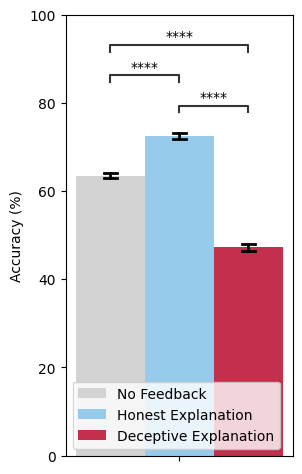

In [ ]:
def plotter(data, name, hue, palette):
    data['explanation_type'] = data['explanation_type'].map({'No Feedback':'No Feedback', 'Honest': 'Honest Explanation', 'Deceptive':'Deceptive Explanation'})
    data['Accuracy (%)'] = data['second_rating_accuracy']

    # Plot settings
    plot_params = {
        'x': "x-axis",
        'y' : "Accuracy (%)",
        'hue' : hue,
        'data' : data,
        'palette': palette,
        'hue_order' : ["No Feedback","Honest Explanation","Deceptive Explanation"],
    }
    # Stats
    stats(**plot_params, graph_viz=True, title="", ylim=[0,100], figsize=[3,5], stats_viz=True, plot_params=plot_params)


blue_palette = sns.set_palette(sns.color_palette([lightgrey, blue, red]))
plotter(result_df[(result_df.trivia==0) & (result_df.explanation == 1)],"Truth Ratings of News Headlines","explanation_type", blue_palette)

#### BELIEF EFFECTS BY TRUE/FALSE

['Deceptive Explanation' 'Honest Explanation' 'No Feedback']
----
Within the 'True' group of 'Ground Truth':
----
Running stats between the samples: ['Deceptive Explanation', 'Honest Explanation', 'No Feedback']
> Sample size sufficient
   > Sample sizes are unequal and homogeneity *NOT MET*: w_levene=42.60383329874551, p_levene=4.0195575878991104e-19
         > Thus running ANOVA Welch:
            > ANOVA Welch *SIGNIFICANT*: welch=
             Source  ddof1        ddof2           F          p-unc       np2
0  explanation_type      2  3990.755626  844.810277  1.160799e-306  0.182567

>Thus running Games-Howell test:
                       A                   B  mean(A)  mean(B)   diff     se  \
0  Deceptive Explanation  Honest Explanation    2.363    3.775 -1.413  0.035   
1  Deceptive Explanation         No Feedback    2.363    3.263 -0.901  0.031   
2     Honest Explanation         No Feedback    3.775    3.263  0.512  0.030   

        T        df  pval  hedges  
0 -40.768  3637.

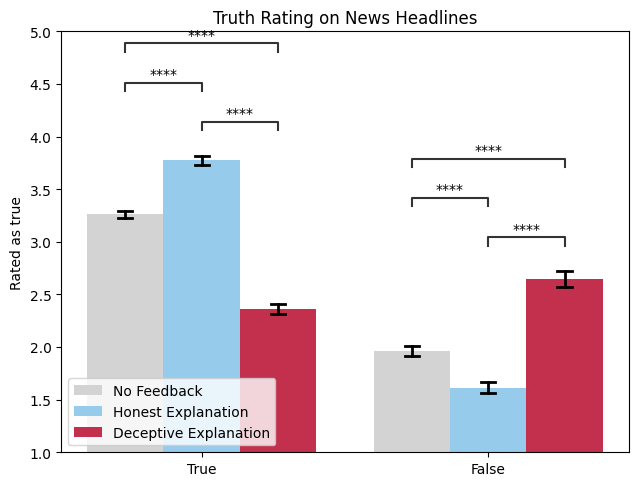

In [ ]:
# Plot

def plotter(data, name, hue, palette):

    data['explanation_type'] = data['explanation_type'].map({'No Feedback':'No Feedback', 'Honest': 'Honest Explanation', 'Deceptive':'Deceptive Explanation'})
    print(data['explanation_type'].unique())

    data['Rated as true'] = data['second_rating']
    data['Ground Truth'] = data['true_statement'].map({0:'False', 1: 'True'})

    # Plot settings
    plot_params = {
        'x': "Ground Truth",
        'y' : "Rated as true",
        'hue' : hue,
        'data' : data,
        'palette': palette,
        'order' : ["True", "False"],
        'hue_order' : ["No Feedback","Honest Explanation","Deceptive Explanation"],
    }

    # Stats
    stats(**plot_params, graph_viz=True, title=name, ylim=[1,5], figsize=None, stats_viz=True, plot_params=plot_params)


blue_palette = sns.set_palette(sns.color_palette([lightgrey, blue, red]))
plotter(result_df[(result_df.trivia==0) & (result_df.explanation == 1)],"Truth Rating on News Headlines","explanation_type", blue_palette)
#plotter(result_df[(result_df.trivia==1)],"Truth Rating on Trivia Statements","explanation_type", blue_palette)

#### SPLIT BY CLASSIFICATION / EXPLANATION


['GPT Explanation' 'No Explanation' 'No Feedback']
['Deceptive' 'No Feedback']


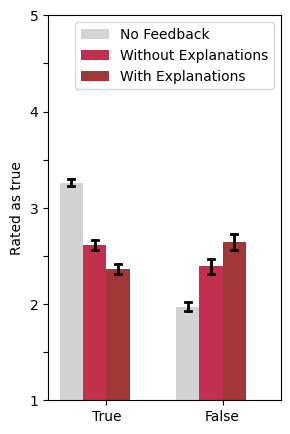

In [ ]:
def plotter(data, name, hue, palette):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    print(data['text_explanation'].unique())
    data['text_explanation'] = data['text_explanation'].map({'No Feedback':'No Feedback', 'GPT Explanation': 'With Explanations', 'No Explanation':'Without Explanations'})
    print(data['explanation_type'].unique())
    ax = sns.barplot(x="true_statement", y="second_rating",hue=hue,
                     order = [1, 0],
                     hue_order=["No Feedback", "Without Explanations", "With Explanations", ""],
                     data=data,
                     alpha=.99,
                     errcolor="black", errwidth=2, capsize=.05,
                     palette=palette)
    ax.set_ylabel("Rated as true")
    ax.set_xlabel("")
    ax.set_xticklabels(['True', 'False'])
    ax.legend()
    ax.set_ylim(1,5)
    ax.set_yticklabels(["1","","2","","3","","4","","5"])
    #ax.set_title("{}".format(name))
    fig.savefig("{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([lightgrey, red, darkred, red]))
plotter(result_df[(result_df.trivia==0) & (result_df.deceptive_feedback==1)],"deception_breakdown_news","text_explanation", blue_palette)
blue_palette = sns.set_palette(sns.color_palette([lightgrey, blue, darkblue, red]))
#plotter(result_df[(result_df.trivia==0) & (result_df.deceptive_feedback==0)],"honest_breakdown_news","text_explanation", blue_palette)
#plotter(result_df[(result_df.trivia==1) & (result_df.deceptive_feedback==1)],"deception_breakdown_trivia","text_explanation", blue_palette)

#### VALIDITY

[1 0]
['Logically Invalid' 'Logically Valid']


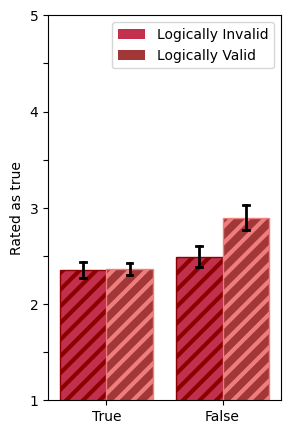

[1 0]
['Logically Invalid' 'Logically Valid']


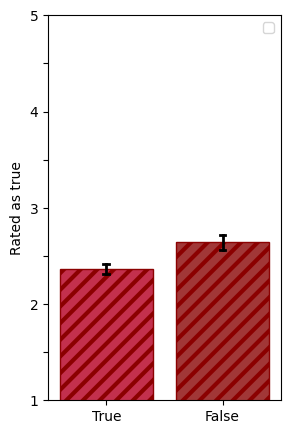

In [ ]:
def plotter(data, name, hue, palette):
    fig = plt.figure()
    plt.rcParams['hatch.linewidth'] = 3
    plt.rcParams["figure.figsize"] = (3,5)
    ax = fig.add_subplot(1,1,1)

    print(data['invalid_statement'].unique())
    data['invalid_statement'] = data['invalid_statement'].map({0: 'Logically Valid', 1:'Logically Invalid'})
    print(data['invalid_statement'].unique())
    ax = sns.barplot(x="true_statement", y="second_rating",hue=hue,
                     order = [1, 0],
                     #hue_order=["Logically Valid", "Logically Invalid"],
                     data=data,
                     alpha=.99,
                     errcolor="black", errwidth=2, capsize=.05,
                     palette=palette)
    ax.set_ylabel("Rated as true")
    ax.set_xlabel("")
    ax.set_xticklabels(['True', 'False'])
    ax.legend()
    ax.set_ylim(1,5)
    ax.set_yticklabels(["1","","2","","3","","4","","5"])
    #ax.set_title("{}".format(name))

    num_x_axis = len(data.true_statement.unique())
    hatches = itertools.cycle(['//', '//'])
    colors = itertools.cycle(["darkred", "lightcoral"])
    for i, bar in enumerate(ax.patches):
        if i % num_x_axis == 0:
            hatch = next(hatches)
            color = next(colors)
        bar.set_edgecolor(color)
        bar.set_hatch(hatch)

    fig.savefig("{}.png".format(name),dpi=600, bbox_inches="tight")
    plt.show()


blue_palette = sns.set_palette(sns.color_palette([red, darkred,"white", "white", darkred, red]))
plotter(result_df[(result_df.trivia==0) & (result_df.deceptive_feedback==1) & (result_df.explanation == 1)],"deception_validity_news","invalid_statement", blue_palette)